In [1]:
#Bibliotécas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve
from sklearn.metrics import classification_report
import scikitplot as skplt
import eli5

In [2]:
df = pd.read_csv('df.csv')

### 1) Construção do modelo de Arvore de Decisões

O modelo final será construído com base nas informações aprendidas na Parte 2, onde estudamos a fundo os hiperparâmetros, sendo testando milhares de interações e diferentes combinações. 

Portanto, nesta etapa, estamos apenas replicando os modelos escolhidos. 

In [3]:
#Separação dos dados para train/test de diferentes modelos, considerando: Dataset inteiro e separado por dois departamentos

X_Sales = df[(df['Department']=='Sales')][df.columns.drop('Attrition')]
y_Sales = df[(df['Department']=='Sales')][['Attrition']]

X_RandD = df[(df['Department']=='Research & Development')][df.columns.drop('Attrition')]
y_RandD = df[(df['Department']=='Research & Development')][['Attrition']]

X_all = df[df.columns.drop('Attrition')]
y_all = df[['Attrition']]


#Separação das colunas numéricas continuas e categóricas que receberão diferentes tratativas no pipeline
numeric_features = df.drop(columns=['Attrition']).select_dtypes(exclude=[object]).columns.values.tolist()
categorical_features = df.select_dtypes(include=[object]).columns.values.tolist()

In [4]:
#Funções das métricas de desempenho

# Matriz de Confusão
def Matriz_Confusao (p_y_test, p_y_pred):
    vn, fp, fn, vp = confusion_matrix(p_y_test, p_y_pred).ravel()
    return vn, fp, fn, vp

#Acuracia
def calcacuracia (vp,fp,vn,fn):
    acuracia = (vp+vn)/(vp+fp+vn+fn)
    return acuracia

#Precisao
def calcprecisao(vp,fp,vn,fn):
    precisao = vp / (vp + fp)
    return precisao

#Revocação
def calcrevocacao(vp,fp,vn,fn):
    revocacao = vp / (vp + fn)
    return revocacao

#F-Medida
def calcfmedida(P,R):
    fmedida = 2 * (P * R / (P + R))
    return fmedida


# Utilizando as funções de report do skplt.metrics
def resultados(res):

    # Medidas de acerto 
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        print(classification_report(res[phase]["actual"], res[phase]["pred"]))
    
    # Matriz de Confusão
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        skplt.metrics.plot_confusion_matrix(res[phase]["actual"], res[phase]["pred"])
        plt.show()
    
    # Curva ROC-AUC
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        skplt.metrics.plot_roc_curve(res[phase]["actual"], res[phase]["prob"])
        plt.show()

    return

Abaixo, criamos três dicionários com os hiperparâmetros selecionados. Os dicionarios serão passados em uma função, a qual terá todo a etapa de treino e teste, assim como um pipeline com o pré-processamento, além das métricas de desempenho e a feature importance do modelo.

In [55]:
#Seleção de hiperparâmetros dos três modelos

param_all = {
    'data':[X_all, y_all],
    'inputer':'median',
    'max_depth':18,
    'criterion': 'gini',
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'splitter': 'best'
       
}

param_sales = {
    'data':[X_Sales, y_Sales],
    'inputer':'median',
    'max_depth':19,
    'criterion': 'entropy',
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'splitter': 'random'
    
}

param_rand = {
    'data':[X_RandD, y_RandD],
    'inputer':'mean',
    'max_depth':17,
    'criterion': 'gini',
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'splitter': 'best'
}

In [30]:
def modelo_final(parametros_dic):
    #Separação dos dados de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(parametros_dic['data'][0], parametros_dic['data'][1], test_size=0.2, random_state=42)


    ##################################################################################
    #Aplicar transformações nos dados de treino e de teste. 


    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder())])

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=parametros_dic['inputer'])),
        ('scaler', StandardScaler())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])


    ##################################################################################
    #Configuração do pipeline e dos hiperparâmetros do modelo 
    clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(
        criterion= parametros_dic['criterion'],
        max_depth= parametros_dic['max_depth'], 
        max_features= parametros_dic['max_features'],
        min_samples_leaf= parametros_dic['min_samples_leaf'],
        min_samples_split= parametros_dic['min_samples_split'],
        splitter= parametros_dic['splitter']



    ))])

    clf.fit(X_train, y_train)
##################################################################################
    y_pred = clf.predict(X_test)

    vn, fp, fn, vp = Matriz_Confusao (y_test, y_pred)
    Acuracia = calcacuracia(vp,fp,vn,fn)
    P = calcprecisao(vp,fp,vn,fn)
    R = calcrevocacao(vp,fp,vn,fn)
    FMedida = calcfmedida(P,R)
    
    print('Matriz de Confusão:')
    print('VP:', vp)
    print('FP:', fp)
    print('VN:', vn)
    print('FN:', fn)
    print('------')
    print('Acuracia:',Acuracia)
    print('Precisao:',P)
    print('Revocação:',R)
    print('F-Medida:', FMedida)
    print('__________________________________')
    ##################################################################################
    #Matriz de Confusão 
    Results = {"train": {"actual": y_train,
               "pred": clf.predict(X_train),
               "prob": clf.predict_proba(X_train)},

       "test": {"actual": y_test,
               "pred": clf.predict(X_test),
               "prob": clf.predict_proba(X_test)}}

    ##################################################################################
    #Feature weight
    resultados(Results)
    
    onehot_columns = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['one_hot'].get_feature_names(input_features=categorical_features)
    numeric_features_list = list(numeric_features)
    numeric_features_list.extend(onehot_columns)
    return eli5.explain_weights(clf.named_steps['classifier'], top=50, feature_names=numeric_features_list, feature_filter=lambda x: x != '<BIAS>')

#### 1.1 - Modelo com o dataset inteiro

Matriz de Confusão:
VP: 134
FP: 4
VN: 737
FN: 7
------
Acuracia: 0.9875283446712018
Precisao: 0.9710144927536232
Revocação: 0.950354609929078
F-Medida: 0.9605734767025089
__________________________________
-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2958
           1       1.00      1.00      1.00       570

    accuracy                           1.00      3528
   macro avg       1.00      1.00      1.00      3528
weighted avg       1.00      1.00      1.00      3528

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       741
           1       0.97      0.95      0.96       141

    accuracy                           0.99       882
   macro avg       0.98      0.97      0.98       882
weighted avg       0.99      0.99     

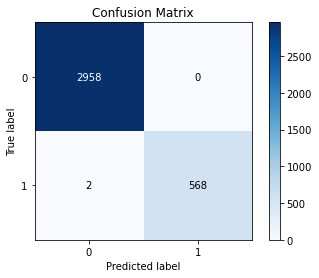

-------------------------------------------------------------
Evaluating test


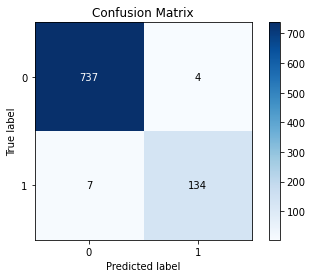

-------------------------------------------------------------
Evaluating train


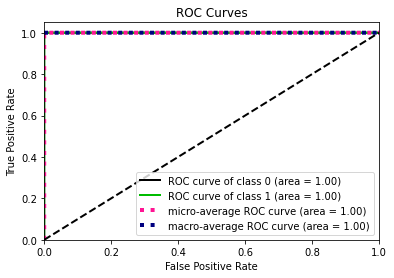

-------------------------------------------------------------
Evaluating test


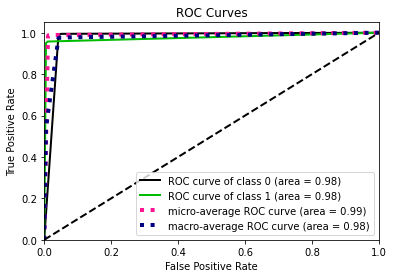

Weight,Feature
0.1238,delta_min_year
0.0874,Age
0.0734,MonthlyIncome
0.0610,YearsAtCompany
0.0606,YearsWithCurrManager
0.0538,YearsSinceLastPromotion
0.0512,DistanceFromHome
0.0414,NumCompaniesWorked
0.0320,PercentSalaryHike
0.0312,JobSatisfaction


In [31]:
modelo_final(param_all)

Para o dataset inteiro, chegamos a um a um alto nível de precisão, nos dados de teste, temos uma acuária de 99%, e f-medida de 96%. 

O modelo de treino aparentemente ficou com quase 100% de acurácia, entretanto, pela diferença de menos de 10% em relação aos dados de teste, entendemos que não ocorreu overfit. 

E por fim, as 5 atributos/features de maior peso no modelo, foram: delta_min_year,Age, MonthlyIncome, YearsAtCompany e YearsWithCurrManager.

#### 1.2 - Modelo com o dataset do departamento de Sales

Matriz de Confusão:
VP: 36
FP: 1
VN: 228
FN: 3
------
Acuracia: 0.9850746268656716
Precisao: 0.972972972972973
Revocação: 0.9230769230769231
F-Medida: 0.9473684210526315
__________________________________
-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       908
           1       1.00      1.00      1.00       162

    accuracy                           1.00      1070
   macro avg       1.00      1.00      1.00      1070
weighted avg       1.00      1.00      1.00      1070

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       229
           1       0.97      0.92      0.95        39

    accuracy                           0.99       268
   macro avg       0.98      0.96      0.97       268
weighted avg       0.98      0.99      

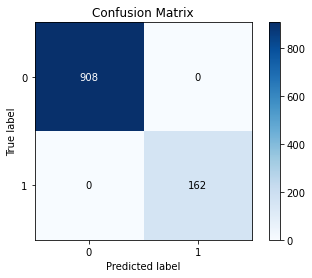

-------------------------------------------------------------
Evaluating test


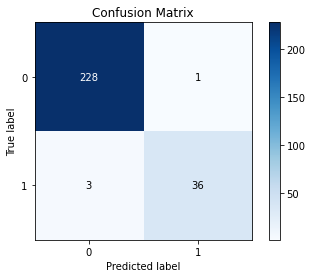

-------------------------------------------------------------
Evaluating train


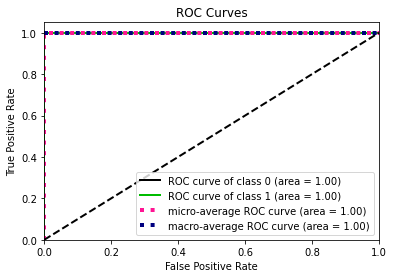

-------------------------------------------------------------
Evaluating test


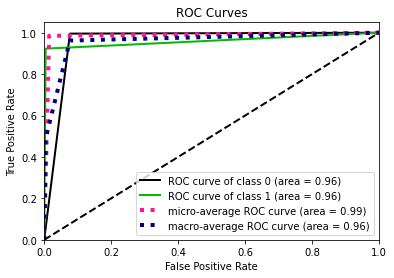

Weight,Feature
0.0895,delta_min_year
0.0713,EnvironmentSatisfaction
0.0671,DistanceFromHome
0.0610,NumCompaniesWorked
0.0565,JobSatisfaction
0.0562,StockOptionLevel
0.0511,TrainingTimesLastYear
0.0480,YearsAtCompany
0.0423,JobLevel
0.0353,Education


In [45]:
modelo_final(param_sales)

Para o dataset apenas do departamento de sales, chegamos a um a um alto nível de precisão, nos dados de teste, temos uma acuária de 99%, e f-medida de 94%. 

O modelo de treino aparentemente ficou com quase 100% de acurácia, entretanto, pela diferença de menos de 10% em relação aos dados de teste, entendemos que não ocorreu overfit. Entretanto, para o dataset de sales, tivemos maior dificuldade em controlar o overfitting, isso pode ser atribuido principalmente por causa do pequeno tamanho do dataset. 

Para o dataset de sales, tivemos um diferente conjunto de features_importance que tiveram maior peso. Entretanto, delta_min_year ainda é o feature mais importante. 

#### 1.3 - Modelo com o dataset do departamento de Research and Development

Matriz de Confusão:
VP: 87
FP: 7
VN: 478
FN: 5
------
Acuracia: 0.9792027729636048
Precisao: 0.925531914893617
Revocação: 0.9456521739130435
F-Medida: 0.935483870967742
__________________________________
-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1945
           1       1.00      1.00      1.00       361

    accuracy                           1.00      2306
   macro avg       1.00      1.00      1.00      2306
weighted avg       1.00      1.00      1.00      2306

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       485
           1       0.93      0.95      0.94        92

    accuracy                           0.98       577
   macro avg       0.96      0.97      0.96       577
weighted avg       0.98      0.98      0

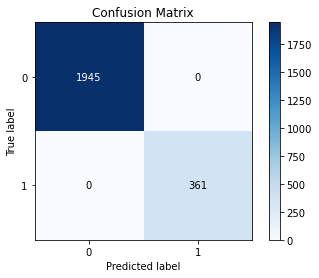

-------------------------------------------------------------
Evaluating test


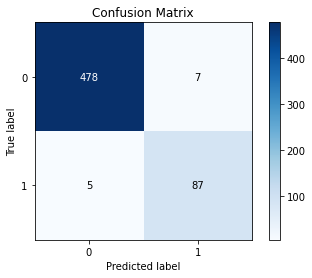

-------------------------------------------------------------
Evaluating train


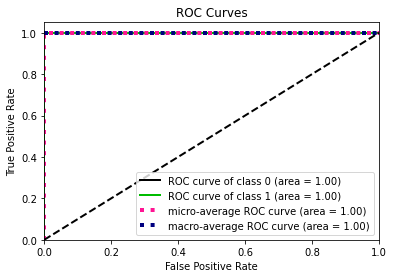

-------------------------------------------------------------
Evaluating test


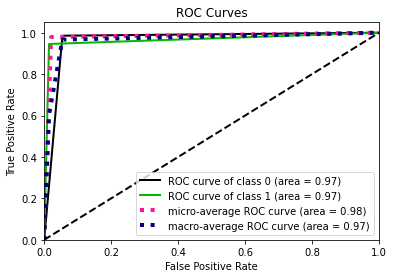

Weight,Feature
0.1120,delta_min_year
0.0920,Age
0.0770,TotalWorkingYears
0.0762,MonthlyIncome
0.0617,NumCompaniesWorked
0.0411,MaritalStatus_Single
0.0378,JobLevel
0.0377,PercentSalaryHike
0.0370,JobRole_Sales Executive
0.0364,DistanceFromHome


In [56]:
modelo_final(param_rand)

Para o dataset apenas do departamento de sales, chegamos a um a um alto nível de precisão, nos dados de teste, temos uma acuária de 98%, e f-medida de 94%. 

O modelo de treino aparentemente ficou com quase 100% de acurácia, entretanto, pela diferença de menos de 10% em relação aos dados de teste, entendemos que não ocorreu overfit. Entretanto, também para o dataset de r&d, tivemos maior dificuldade em controlar o overfitting, isso pode ser atribuido principalmente por causa do pequeno tamanho do dataset. 

Para o dataset de sales, tivemos um diferente conjunto de features_importance que tiveram maior peso. Entretanto, delta_min_year ainda é o feature mais importante. 

### 2) Conclusões gerais

Para os três cenários propostos, conseguir modelos com acurácia superior a 90%.

Destacando-se a importância da etapa de engenharia de atributos, onde o fator workload, representado principalmente pelo atributo "detal_min_year", foi fundamental no treinamento do modelo, sendo a feature_importance com maior peso. 

Quando comparamos os departamentos Sales e R&D, verificamos que com a exceção do fator workload, o feature_importance é relativamente diferente entre ambos os cenários. Validando a hipotese de que diferentes departamentos, possuem diferentes características que afetam o Attrition.

O hiperparâmetro de max_depth foi o principal fator de influência no ajuste dos modelos, visto que um valor superior a 20, claramente induzia overfitting. Fazendo com que o modelo ficasse extremamente enviesado. Essa diferença era notada quando comparamos os resultados de acurácia entre treino e teste.